# ICE Contractor Analysis
Following my analysis of federal contracts to the private prisons CoreCivic and Geo Group, this notebook analyzes publically avaiable contracts from the Immigration and Customs Enforcement Agency (ICE). This analysis uses data downloaded from the new USASpending.gov [dashboard](https://www.usaspending.gov/#/search/1da7f3124d80741313219fd741632538), specifically I filtered `Funding Agency` with "U.S. Immigration and Customs Enforcement (ICE) | Sub-Agency".

In [1]:
import glob
import datetime
import numpy as np
import pandas as pd

In [2]:
# data downloaded from USAspending.gov
input_file_pattern = 'ice_data/data_in/prime_awards_ice_funded/*'

In [3]:
files = glob.glob(input_file_pattern)
files

['ice_data/data_in/prime_awards_ice_funded/all_contracts_subawards_1.csv',
 'ice_data/data_in/prime_awards_ice_funded/all_contracts_prime_awards_1.csv',
 'ice_data/data_in/prime_awards_ice_funded/all_assistance_prime_awards_1.csv',
 'ice_data/data_in/prime_awards_ice_funded/all_assistance_subawards_1.csv']

Let's just look at prime contracts today.

In [4]:
df_prime_contracts = pd.read_csv(files[1])

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (13,32,70,71,98,127) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Something to note here, if we don't filter out funding agency we get some inaccuracies!

In [5]:
{
    'awarding_sub_agency_name' : 'U.S. IMMIGRATION AND CUSTOMS ENFORCEMENT', # N = 15952
    'funding_sub_agency_name' : 'U.S. IMMIGRATION AND CUSTOMS ENFORCEMENT', # N = 13909
}

{'awarding_sub_agency_name': 'U.S. IMMIGRATION AND CUSTOMS ENFORCEMENT',
 'funding_sub_agency_name': 'U.S. IMMIGRATION AND CUSTOMS ENFORCEMENT'}

In [54]:
# here we're filtering only when ICE awards a contract
df_prime_contracts = df_prime_contracts[
    df_prime_contracts['awarding_sub_agency_name'] == 'U.S. IMMIGRATION AND CUSTOMS ENFORCEMENT'
]

len(df_prime_contracts)

13909

In [8]:
# there are a lot of columns!
prime_cols = df_prime_contracts.columns
num_cols = len(prime_cols)
print(f"There are {num_cols} columns in this file!\nHere are some of the column names:")
prime_cols.values.tolist()[:20]

There are 247 columns in this file!
Here are some of the column names:


['award_id_piid',
 'parent_award_agency_id',
 'parent_award_agency_name',
 'parent_award_id',
 'obligated_amount',
 'current_total_value_of_award',
 'potential_total_value_of_award',
 'period_of_performance_start_date',
 'period_of_performance_current_end_date',
 'period_of_performance_potential_end_date',
 'ordering_period_end_date',
 'awarding_agency_code',
 'awarding_agency_name',
 'awarding_sub_agency_code',
 'awarding_sub_agency_name',
 'awarding_office_code',
 'awarding_office_name',
 'funding_agency_code',
 'funding_agency_name',
 'funding_sub_agency_code']

That is a lot of columns, here are the definitions of the columns we'll be using here:

## Glossary of fields used in this Analysis with Definitions from USASpending:
`recipient_duns`<br>
The unique identification number for the ultimate parent of an awardee or recipient. Currently the identifier is the 9-digit number maintained by Dun & Bradstreet as the global parent DUNS® number.



`potential_total_value_of_award`<br>
The total amount that could be obligated on a contract. This total includes the base plus options amount. For example, if a recipient is awarded 10M on a base contract with 3 option years at 1M each, the potential award amount is 13M.

`current_total_value_of_award` <br>
The amount of money that the government has promised (obligated) to pay a recipient for a contract. This means the base amount and any exercised options.

`period_of_performance_start_date`<br>
The date that the award begins.

`period_of_performance_potential_end_date`<br>
For procurement, the date on which, for the award referred to by the action being reported if all potential pre-determined or pre-negotiated options were exercised, awardee effort is completed or the award is otherwise ended. Administrative actions related to this award may continue to occur after this date. This date does not apply to procurement indefinite delivery vehicles under which definitive orders may be awarded.

`funding_sub_agency_name`<br>
A Funding Agency pays for the majority of funds for an award out of its budget. Typically, the Funding Agency is the same as the Awarding Agency. In some cases, one agency will administer an award (Awarding Agency) and another agency will pay for it (Funding Agency).

`awarding_sub_agency_name`<br>
The Awarding Sub Agency is the sub agency that issues and administers the award. For example, the Internal Revenue Service (IRS) is a sub agency of the Department of the Treasury.

<hr>

Thanks for providing that glossary USASpending, let's do some minor data wrangling and get some summary statistics.

In [9]:
date_cols = ['period_of_performance_start_date', 'period_of_performance_potential_end_date']
for col in date_cols:
    df_prime_contracts[col] = pd.to_datetime(df_prime_contracts[col])

In [10]:
total_spend = df_prime_contracts['current_total_value_of_award'].sum()
potential_spend = df_prime_contracts['potential_total_value_of_award'].sum()
at_stake =  potential_spend - total_spend

num_contractors = len(df_prime_contracts['recipient_duns'].unique())
first_contract = df_prime_contracts['period_of_performance_start_date'].min().strftime('%Y-%m-%d')

print("ICE has invested ${:,.2f} in contracts with {} Prime contractors "
      "since {}.\nICE has ${:,.2f} in potential payouts with active contracts.".format(
          total_spend, num_contractors, first_contract, at_stake))

ICE has invested $5,782,367,558.34 in contracts with 2999 Prime contractors since 2006-10-01.
ICE has $9,470,935,667.50 in potential payouts with active contracts.


Let's sort this data by the contract end date

In [11]:
df_prime_contracts.sort_values(by=['period_of_performance_potential_end_date'], 
                               ascending=False, 
                               inplace=True)

There are typos in the recipient names, so let's use their DUNs IDs for aggregate analysis.<br>
We can create a `lookup_table` containing the latest name and contact info

In [12]:
lookup_cols = [
    'recipient_parent_duns',
    'recipient_parent_name', 
    'recipient_address_line_1', 
    'recipient_address_line_2',
    'recipient_city_name', 
    'recipient_state_code', 
    'recipient_state_name',
    'recipient_zip_4_code', 
    'recipient_congressional_district',
    'recipient_phone_number', 
    'recipient_fax_number'
]

In [13]:
lookup_table = df_prime_contracts.drop_duplicates(
    subset = ['recipient_parent_duns'],
    keep = 'first'
)[lookup_cols]

There are contractors with similar names (and different DUNS), we can find similar names using fuzzywuzzy, and replace them for aggregation.

In [14]:
from fuzzywuzzy import fuzz

/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [15]:
look_up_names = lookup_table[~lookup_table.recipient_parent_name.isnull()].recipient_parent_name.unique()
look_up_names.sort()

In [16]:
window_size = 10 # look at to words to the right and left
threshold = 90   # how similar is enough?

skip = []
switch_name = dict()
for i, comp in enumerate(look_up_names):
    if comp not in skip:
        window = np.concatenate((look_up_names[i-window_size: i], 
                                 look_up_names[i+1: i+window_size]))
        for to_search in window:
            similarity_score = fuzz.token_sort_ratio(comp, to_search)
            if similarity_score >= threshold:
                switch_name[comp] = to_search
                skip += [to_search]

Let's swamp out the fuzzy names!

In [17]:
df_prime_contracts.recipient_parent_name.replace(switch_name, 
                                                 inplace = True)

In [18]:
lookup_table.recipient_parent_name.replace(switch_name, 
                                           inplace = True)

lookup_table.drop_duplicates(subset = ['recipient_parent_name'],
                             keep = 'first',
                             inplace = True)

Now let's get how much each company has been rewarded, how much they have the potential to be rewarded, how many awards they're been granted, and when their contracts are finished. This code is chained, and kind of messy. Each line aggreagates by the recipient ID, and performs some sort of agg function, and then sorts the values according to the total of the agg function.

In [19]:
contract_amounts = (
    df_prime_contracts.groupby('recipient_parent_name').current_total_value_of_award.sum()
).sort_values(ascending=False)

In [20]:
contract_potential = (
    df_prime_contracts.groupby('recipient_parent_name').potential_total_value_of_award.sum()
)

In [21]:
num_awards = (
    df_prime_contracts.groupby('recipient_parent_name').award_id_piid.nunique()
)

In [57]:
award_ids = (
    df_prime_contracts.groupby('recipient_parent_name').award_id_piid.unique().str.join(', ')
)

In [22]:
contract_enddate = (
    df_prime_contracts[
        ~df_prime_contracts['period_of_performance_potential_end_date'].isnull()
    ].groupby('recipient_parent_name').period_of_performance_potential_end_date.max()
)

In [23]:
contract_startdate = (
    df_prime_contracts[
        ~df_prime_contracts['period_of_performance_start_date'].isnull()
    ].groupby('recipient_parent_name').period_of_performance_start_date.min()
)

For context, let's see what kinds of services each of these companies provide by counting the most frequent words in service descriptions per contractor.

In [24]:
from collections import Counter
from nltk.corpus import stopwords

In [25]:
def count_words(row, counter, sw):
    '''
    Splits sentences, casts words to lowercase, and counts all words that aren't in stopwords (sw)
    '''
    row_clean = str(row).replace('-', ' ').replace('/', ' ').lower()
    counter.update([w for w in row_clean.split() if w not in sw])

In [26]:
sw = stopwords.words('English')

In [27]:
top_words = []
for company_, df_ in df_prime_contracts.groupby('recipient_parent_name'):
    word_counter_ = Counter()
    df_['product_or_service_code_description'].apply(count_words, 
                                                     args = (word_counter_, sw,))
    # get top 5 words
    top_words_ = ', '.join([w for w, c in word_counter_.most_common(5)])
    
    # create a dcitonary, and add it to the list
    d_ = dict(top_words_from_serv_desc = top_words_,
              recipient_parent_name = company_)
    
    top_words.append(d_)
    
top_words_per_service_description = pd.DataFrame(top_words)

We can join them all together using this craziness below:

In [60]:
output = (
    contract_amounts.reset_index()
        .merge(
          num_awards.reset_index(), 
          on='recipient_parent_name',
        )
        .merge(
          contract_potential.reset_index(), 
          on='recipient_parent_name'
        )
        .merge(
          contract_enddate.reset_index(), 
          on='recipient_parent_name'
        )
        .merge(
          contract_startdate.reset_index(), 
          on='recipient_parent_name'
        )
        .merge(
          top_words_per_service_description, 
          on='recipient_parent_name'
        )
        .merge(
          award_ids.reset_index(),
          on='recipient_parent_name'
        )
        .merge(
          lookup_table,
          on='recipient_parent_name'
        )
    )

The last merge above is the look_up table, containing metadata for each recipient.<br>
Let's change some of the aggregate column names to be more decriptive:

In [63]:
remapping = {
    'current_total_value_of_award' : 'current_total_value_of_awards_USD',
    'potential_total_value_of_award' : 'potential_total_value_of_awards_USD',
    'period_of_performance_potential_end_date' : 'last_contract_end_date',
    'period_of_performance_start_date' : 'first_contract_start_date',
    'award_id_piid_x' : 'number_of_prime_awards',
    'award_id_piid_y' : 'award_id_piids'
}

In [64]:
output.columns = [remapping.get(c, c) for c in output.columns]

In [65]:
# convert datetimes
for col in ['last_contract_end_date', 'first_contract_start_date']:
    output[col] = output[col].dt.strftime('%Y-%m-%d')

Let's timestamp when this file was made.

In [66]:
output['analysis_date'] = datetime.datetime.now() # when was this file made?
output['raw_data_download_date'] = datetime.datetime(2018,6,27) # when was raw data downloaded?

And lastly, let's re-order the columns so they're readable

In [67]:
order_cols = [
    'recipient_parent_name',
    'recipient_parent_duns',
    'top_words_from_serv_desc',
    'number_of_prime_awards',
    'current_total_value_of_awards_USD',
    'potential_total_value_of_awards_USD',
    'award_id_piids',
    'first_contract_start_date',
    'last_contract_end_date',
    'recipient_address_line_1',
    'recipient_address_line_2',
    'recipient_city_name', 
    'recipient_state_code', 
    'recipient_state_name',
    'recipient_zip_4_code',
    'recipient_congressional_district',
    'recipient_phone_number', 
    'recipient_fax_number',
    'analysis_date',
    'raw_data_download_date'
]

# make these human
new_cols = [' '.join(c.split('_')).title() for c in order_cols]

Here is the output:

In [68]:
out_order = output[order_cols]
out_order.columns = new_cols

In [69]:
out_order.head(50)

,Recipient Parent Name,Recipient Parent Duns,Top Words From Serv Desc,Number Of Prime Awards,Current Total Value Of Awards Usd,Potential Total Value Of Awards Usd,Award Id Piids,First Contract Start Date,Last Contract End Date,Recipient Address Line 1,Recipient Address Line 2,Recipient City Name,Recipient State Code,Recipient State Name,Recipient Zip 4 Code,Recipient Congressional District,Recipient Phone Number,Recipient Fax Number,Analysis Date,Raw Data Download Date
0,SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,078745061,"telecom, systems, development, analysis, house...",8,5.322573e+08,7.048101e+08,"HSCETC09J00034,HSCETC10J00005,HSCOW5D0056,HSCE...",2015-06-04,2015-09-24,1710 SAIC DR,NaN,MCLEAN,VA,VIRGINIA,22102,NaN,7036765681,7036765063,2018-06-27 23:15:47.700996,2018-06-27
1,CSI AVIATION SERVICES INC.,102793460,"travel, air, passenger, transportation, reloca...",15,5.181356e+08,6.548366e+08,"HSCECR14F00009,HSCECR14F00007,HSCECR14F00015,H...",2009-10-05,2018-06-30,3700 RIO GRANDE BLVD NW,NaN,ALBUQUERQUE,NM,NEW MEXICO,871072876,01,5057619000,5053427377,2018-06-27 23:15:47.700996,2018-06-27
2,THE GEO GROUP INC,612706465,"guard, housekeeping, services, support, profes...",51,4.086709e+08,2.422247e+09,"70CDCR18FR0000045,HSCEDM11J00054,70CDCR18FR000...",2007-06-01,2029-10-11,621 NW 53RD ST STE 700,NaN,BOCA RATON,FL,FLORIDA,334878242,22,5619997359,5619997648,2018-06-27 23:15:47.700996,2018-06-27
3,INGENESIS INC.,019992424,"medical, general, health, care",2,3.169523e+08,4.215441e+08,"70CDCR18C00000002,HSCECR12F00048",2018-06-21,2018-07-15,10231 KOTZEBUE ST,NaN,SAN ANTONIO,TX,TEXAS,782174430,21,2103660033,2105684582,2018-06-27 23:15:47.700996,2018-06-27
4,SPECTRUM SECURITY SERVICES INC.,618954465,"guard, housekeeping, services",13,1.847043e+08,3.547660e+08,"70CDCR18FR0000046,70CDCR18FC0000013,70CDCR18FC...",2009-12-09,2018-12-11,13967 HIGHWAY 94 STE 101,NaN,JAMUL,CA,CALIFORNIA,919353232,50,NaN,NaN,2018-06-27 23:15:47.700996,2018-06-27
5,CORRECTIONS CORPORATION OF AMERICA,159734151,"guard, housekeeping, support, services, profes...",31,1.810741e+08,5.535522e+08,"70CDCR18FR0000058,70CDCR18FR0000065,70CDCR18FC...",2010-04-29,2019-06-30,10 BURTON HILLS BLVD,NaN,NASHVILLE,TN,TENNESSEE,372156105,05,6152636713,6152633090,2018-06-27 23:15:47.700996,2018-06-27
6,NANA REGIONAL CORPORATION INC,079253761,"housekeeping, guard, fiber, optic, cables",12,1.534640e+08,7.979546e+08,"HSCEDM15J00019,70CDCR18FR0000051,70CDCR18FR000...",2016-06-21,2024-04-30,3901 OLD INTERNATIONAL AIRPORT RD STE 200-G,NaN,ANCHORAGE,AK,ALASKA,99502,00,7037666837,7037666906,2018-06-27 23:15:47.700996,2018-06-27
7,M V M INC.,038049532,"housekeeping, guard, support, administrative:,...",34,1.480560e+08,6.292661e+08,"HSCEMS17F00040,HSCEDM14J00035,70CDCR18FR000006...",2010-09-20,2022-08-03,44620 GUILFORD DR STE 150,NaN,ASHBURN,VA,VIRGINIA,201476063,10,5712234620,5712234487,2018-06-27 23:15:47.700996,2018-06-27
8,AHTNA INCORPORATED,069586055,"housekeeping, guard, maint, rep, alt",8,1.260482e+08,4.670787e+08,"70CDCR18FR0000003,HSCEDM17J00007,HSCEDM16J0000...",2011-10-21,2018-11-30,110 W 38TH AVE STE 200D,NaN,ANCHORAGE,AK,ALASKA,995035677,00,9073346477,9073346750,2018-06-27 23:15:47.700996,2018-06-27
9,CLASSIC AIR CHARTER INC.,961704876,"travel, transportation, relocation, lodging, r...",1,1.255691e+08,6.354194e+08,70CDCR18FR0000002,2018-04-13,2023-06-30,460 NEW YORK AVE,NaN,HUNTINGTON,NY,NEW YORK,117433432,03,6315495021,NaN,2018-06-27 23:15:47.700996,2018-06-27


There are still a lot of duplicates, future work will be fuzzy matching these accounts.<br>
Let's save this as a csv.

In [70]:
outfile = 'ice_data/data_out/ice_prime_contractors_aggregated_clean.csv'
out_order.to_csv(outfile, index=False)

In [71]:
import math

millnames = ['',' K',' M',' B',' T']

def millify(n):
    if not np.isnan(n):
        n = float(n)
        millidx = max(0,min(len(millnames)-1,
                            int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

        return '{:.2f}{}'.format(n / 10**(3 * millidx), millnames[millidx])
    return np.nan

In [72]:
# to make it more human, smh...
for col in ['Current Total Value Of Awards Usd', 'Potential Total Value Of Awards Usd']:
    out_order[col] = out_order[col].apply(millify)

In [73]:
outfile = 'ice_data/data_out/ice_prime_contractors_aggregated_clean_numbers.csv'
out_order.to_csv(outfile, index=False)

In [74]:
out_order.head(2)

,Recipient Parent Name,Recipient Parent Duns,Top Words From Serv Desc,Number Of Prime Awards,Current Total Value Of Awards Usd,Potential Total Value Of Awards Usd,Award Id Piids,First Contract Start Date,Last Contract End Date,Recipient Address Line 1,Recipient Address Line 2,Recipient City Name,Recipient State Code,Recipient State Name,Recipient Zip 4 Code,Recipient Congressional District,Recipient Phone Number,Recipient Fax Number,Analysis Date,Raw Data Download Date
0,SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,078745061,"telecom, systems, development, analysis, house...",8,532.26 M,704.81 M,"HSCETC09J00034,HSCETC10J00005,HSCOW5D0056,HSCE...",2015-06-04,2015-09-24,1710 SAIC DR,NaN,MCLEAN,VA,VIRGINIA,22102,NaN,7036765681,7036765063,2018-06-27 23:15:47.700996,2018-06-27
1,CSI AVIATION SERVICES INC.,102793460,"travel, air, passenger, transportation, reloca...",15,518.14 M,654.84 M,"HSCECR14F00009,HSCECR14F00007,HSCECR14F00015,H...",2009-10-05,2018-06-30,3700 RIO GRANDE BLVD NW,NaN,ALBUQUERQUE,NM,NEW MEXICO,871072876,01,5057619000,5053427377,2018-06-27 23:15:47.700996,2018-06-27


## Plotting Top Contractors

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

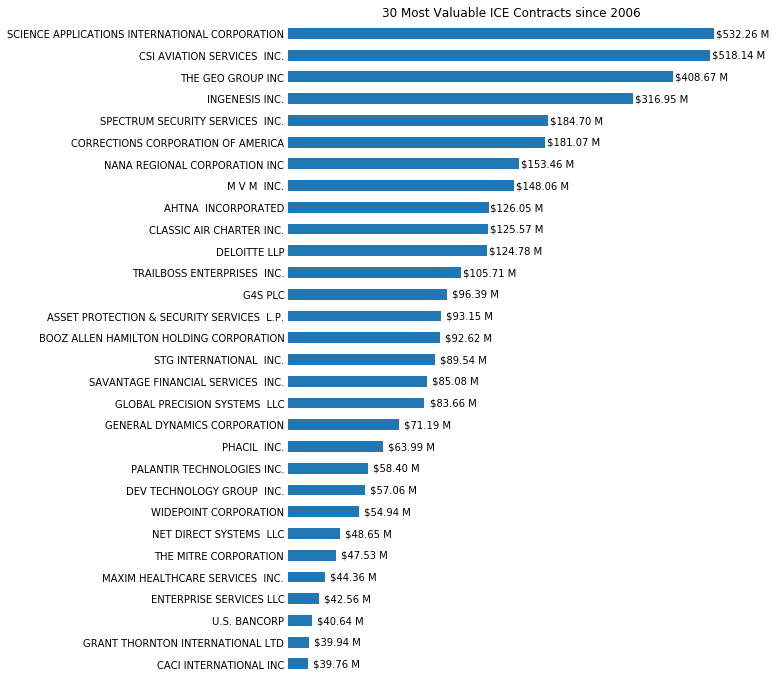

In [75]:
ax = output.head(30).plot(x='recipient_parent_name', 
                          y='current_total_value_of_awards_USD', 
                          kind='barh',
                          logx=True,
                          figsize=(8,12),
                          title= "30 Most Valuable ICE Contracts since 2006",
                          legend=False)
# annotate each bar
for rect in ax.patches: 
    width = rect.get_width()
    ax.text(1.2*rect.get_width(), rect.get_y()+ 0.5 * rect.get_height(),
            '$' + millify(width),
            ha='center', va='center')

# remove boarder    
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remoce axis titles
ax.set_xlabel("")
ax.set_ylabel("")

# remove ticks
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.get_xaxis().set_ticks([])
ax.invert_yaxis();